Gather the mean values of T2 from every BA in the Historical dataset and create a time series analysis

In [1]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import glob

from pathlib import Path

In [2]:
def t2_mean(path):
    
    # input the directory to the set of files as a raw string e.g. r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT'
    files_path = path
    list_of_files = glob.glob(os.path.join(files_path , "*.csv"))
    
    # create a list of the mean of T2 of each file
    means_list = []
    for file_name in list_of_files:
        df = pd.read_csv(file_name, index_col = None, header = 0)
        means_list.append(df['T2'].mean())
    
    means_df = pd.DataFrame(means_list, columns = ["T2_Mean"])
    
    # create list of file names to get more information for each T2
    files = []
    for file_path in list_of_files:
        name = os.path.basename(file_path)
        files.append(name)
     
    # split the file names into lists in BA_list
    BA_list_split = []
    for csv_name in range(len(files)):
        base_name = os.path.splitext(os.path.basename(files[csv_name]))[0]
        split = base_name.split("_")
        BA_list_split.append(split)
        
    # take the first elements (BAs) and last elements (years) and put them into their respective lists
    BA_names = []
    years = []
    for file_list in BA_list_split:
        BA_names.append(file_list[0])
        years.append(file_list[5])
        
    # add BA and Year columns to dataframe and correct the column order
    means_df['BA'] = BA_names
    means_df['Year'] = years

    means_df = means_df[['BA', 'Year', 'T2_Mean']]
    
    return means_df

In [3]:
# create a df for both the cold and hot datasets using t2_mean function
hot_df = t2_mean(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT')
cold_df = t2_mean(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD')

In [5]:
# subset the hot_df using just the data from AEC
hot_AEC = hot_df.loc[(hot_df['BA'] == 'AEC')]

print(hot_AEC)

      BA  Year     T2_Mean
80   AEC  2020  292.535393
81   AEC  2021  292.485079
82   AEC  2022  292.982400
83   AEC  2023  291.887368
84   AEC  2024  292.697961
..   ...   ...         ...
155  AEC  2095  297.899414
156  AEC  2096  297.733642
157  AEC  2097  297.603098
158  AEC  2098  297.228279
159  AEC  2099  297.794693

[80 rows x 3 columns]


In [8]:
# subset the cold_df using just the data from AEC
cold_AEC = cold_df.loc[(cold_df['BA'] == 'AEC')]

print(cold_AEC)

      BA  Year     T2_Mean
80   AEC  2020  292.264766
81   AEC  2021  292.070958
82   AEC  2022  292.543632
83   AEC  2023  291.372831
84   AEC  2024  292.156882
..   ...   ...         ...
155  AEC  2095  295.993833
156  AEC  2096  295.971479
157  AEC  2097  295.843147
158  AEC  2098  295.270059
159  AEC  2099  296.034511

[80 rows x 3 columns]


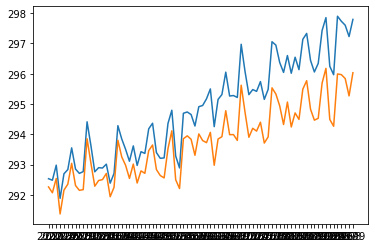

In [9]:
# compare the two AEC T2 means over time with a line graph
plt.plot(hot_AEC['Year'], hot_AEC['T2_Mean'])
plt.plot(cold_AEC['Year'], cold_AEC['T2_Mean'])